In [1]:
# default_exp gan.model

# gan.model

> API details.

In [2]:
# export

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from functools import partial
from torch.nn import BCELoss, CrossEntropyLoss, MSELoss
from tqdm import tqdm

from fastrenewables.synthetic_data import GaussianDataset, plot_class_hists
from fastrenewables.timeseries.model import TemporalCNN
from fastrenewables.tabular.model import EmbeddingModule

### functions:

In [3]:
# export

def flatten_ts(x):
    """assumes matrix of shape (n_samples, n_features, ts_length)"""
    if len(x.shape) in [1,2]:
        return x

    n_samples, n_features, ts_length = x.shape

    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    x = x.reshape(n_samples*ts_length, n_features)
    return x

In [4]:
# export

def LinBnAct(si, so, use_bn, act_cls):
    layers = [nn.Linear(si, so)]
    if use_bn:
        layers += [nn.BatchNorm1d(so)]
    if act_cls is not None:
        layers += [act_cls]
    
    return nn.Sequential(*layers)

### models:

In [5]:
# export

class GANMLP(torch.nn.Module):
    def __init__(self, ann_structure, bn_cont=False, act_fct=torch.nn.ReLU, final_act_fct=nn.Sigmoid, embedding_module=None, transpose=False):
        super(GANMLP, self).__init__()
        
        n_cont = ann_structure[0]
        if embedding_module is not None:
            emb_sz = []
            ann_structure[0] = ann_structure[0] + embedding_module.no_of_embeddings

        self.embedding_module = embedding_module
        
        layers = []
        for idx in range(1, len(ann_structure)):
            cur_use_bn = bn_cont
            cur_act_fct = act_fct()
            if idx == 1 and not bn_cont:
                cur_use_bn = False
            if idx == len(ann_structure)-1:
                cur_act_fct = None
                cur_use_bn = False
                
            layer = LinBnAct(ann_structure[idx-1], ann_structure[idx], cur_use_bn, cur_act_fct)
            layers.append(layer)
        if final_act_fct is not None:
            layers.append(final_act_fct())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x_cat, x_cont):
        if self.embedding_module is not None:
            x_cat = self.embedding_module(x_cat)
            x_cont = torch.cat([x_cat, x_cont], 1)
        
        return self.model(x_cont)

In [6]:
# export
    
class GAN(nn.Module):
    
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, auxiliary=False, auxiliary_weighting_factor=0.1, label_bias=0, label_noise=0):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.real_loss = []
        self.fake_loss = []
        self.aux_loss = []
        self.auxiliary = auxiliary
        self.bce_loss = BCELoss()
        self.auxiliary_loss_function = CrossEntropyLoss()
        self.auxiliary_weighting_factor=auxiliary_weighting_factor
        self.label_bias = label_bias
        self.label_noise = label_noise
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.to_device(self.device)
        
    def noise(self, x):
        z = torch.randn(x.shape[0], self.n_z).to(self.device)
        return z
    
    def to_device(self, device):
        self.device = device
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
        self.bce_loss = self.bce_loss.to(device)
        self.auxiliary_loss_function = self.auxiliary_loss_function.to(device)
        
    def _split_pred(self, y):
        if self.auxiliary:
            y, class_probs = y
        else:
            y, class_probs = y, None
        return y, class_probs
    
    def auxiliary_loss(self, class_probs, y):
        return self.auxiliary_loss_function(class_probs, y.long().squeeze())*self.auxiliary_weighting_factor
    
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(x_cat, x_cont_fake)  
        y_fake, class_probs = self._split_pred(y_fake)
        label = (1-self.label_bias)*torch.ones_like(y_fake) + self.label_noise*torch.randn(y_fake.shape).to(self.device)
        label = label.clamp(0, 1)
        loss = self.bce_loss(y_fake, label)
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            loss = (loss + aux_loss)
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(x_cat, x_cont)
        y_real, class_probs = self._split_pred(y_real)
        label = (1-self.label_bias)*torch.ones_like(y_real) + self.label_noise*torch.randn(y_real.shape).to(self.device)
        label = label.clamp(0, 1)
        real_loss = self.bce_loss(y_real, label)
        self.real_loss.append(real_loss.item())
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            self.aux_loss.append(aux_loss.item())
            real_loss = (real_loss + aux_loss)
        
        real_loss.backward()
        self.dis_optim.step()
        
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(x_cat, x_cont_fake)
        y_fake, class_probs = self._split_pred(y_fake)
        
        label = (0+self.label_bias)*torch.ones_like(y_fake) + self.label_noise*torch.randn(y_fake.shape).to(self.device)
        label = label.clamp(0, 1)
        fake_loss =  self.bce_loss(y_fake, label)
        self.fake_loss.append(fake_loss.item())
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            fake_loss = (fake_loss + aux_loss)
            
        fake_loss.backward()
        self.dis_optim.step()
        return
    
    def forward(self, x_cat, x_cont):
        z = self.noise(x_cont)
        x_gen = self.generator(x_cat, z)
        assert(x_gen.shape == x_cont.shape)
        y = self.discriminator(x_cat, x_gen)
        out = self._split_pred(y)
        return out

In [7]:
# export

class WGAN(GAN):
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, clip=0.01, auxiliary=False):
        super(WGAN, self).__init__(generator, discriminator, gen_optim, dis_optim, n_z, clip, auxiliary)
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.clip = clip
        self.auxiliary = auxiliary
        self.real_loss = []
        self.fake_loss = []
        
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(x_cat, x_cont_fake)
        loss = - y_fake.mean()
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(x_cat, x_cont)
        real_loss = - y_real.mean()
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(x_cat, x_cont_fake)
        fake_loss = y_fake.mean()
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        
        for p in self.discriminator.parameters():
            p = torch.clamp(p, -self.clip, self.clip)
        return

In [8]:
#export    

class AuxiliaryDiscriminator(torch.nn.Module):
    def __init__(self, basic_discriminator, n_classes, final_input_size, len_ts=1, bn=False):
        super(AuxiliaryDiscriminator, self).__init__()
        self.basic_discriminator = basic_discriminator
        self.n_classes = n_classes
        self.final_input_size = final_input_size
        self.len_ts = len_ts
        
        self.adv_layer = nn.Sequential(nn.Linear(self.final_input_size*len_ts, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(self.final_input_size*len_ts, n_classes), nn.Softmax(dim=1))   
        
    def forward(self, cats, conts):
        out = self.basic_discriminator(cats, conts)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return (validity, label)

In [9]:
# export

def get_gan_model(structure, n_classes=2, use_embedding=True, bn=True, gan_type='bce', aux_factor=1, label_noise=0, label_bias=0):
    
    if use_embedding:
        emb_module = EmbeddingModule(categorical_dimensions=[n_classes+1])
    else:
        emb_module = None
          
    gen_structure = structure.copy()
    structure.reverse()
    dis_structure = structure
    dis_structure[-1] = 1
    n_z = gen_structure[0]
    
    if gan_type == 'bce' or gan_type == 'aux':
        final_act_dis = nn.Sigmoid
        opt_fct = torch.optim.Adam
        gan_class = GAN
    elif gan_type == 'wgan':
        final_act_dis = None
        opt_fct = torch.optim.RMSprop
        gan_class = WGAN
       
    generator = GANMLP(ann_structure=gen_structure, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, transpose=True, embedding_module=emb_module, bn_cont=bn)
    if gan_type == 'aux':
        auxiliary = True
        dis_structure = dis_structure[:-1]
        final_input_size = dis_structure[-1]
        discriminator = GANMLP(ann_structure=dis_structure, act_fct=nn.LeakyReLU, final_act_fct=final_act_dis, embedding_module=emb_module, bn_cont=False)
        discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=n_classes, final_input_size=final_input_size)  
    else:
        auxiliary = False
        discriminator = GANMLP(ann_structure=dis_structure, act_fct=nn.LeakyReLU, final_act_fct=final_act_dis, embedding_module=emb_module, bn_cont=False)
        
    gen_opt = opt_fct(params=generator.parameters())
    dis_opt = opt_fct(params=discriminator.parameters())
    model = gan_class(generator=generator, discriminator=discriminator, gen_optim=gen_opt, dis_optim=dis_opt, n_z=n_z, auxiliary=auxiliary, auxiliary_weighting_factor=aux_factor, label_noise=label_noise, label_bias=label_bias)

    return model

100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


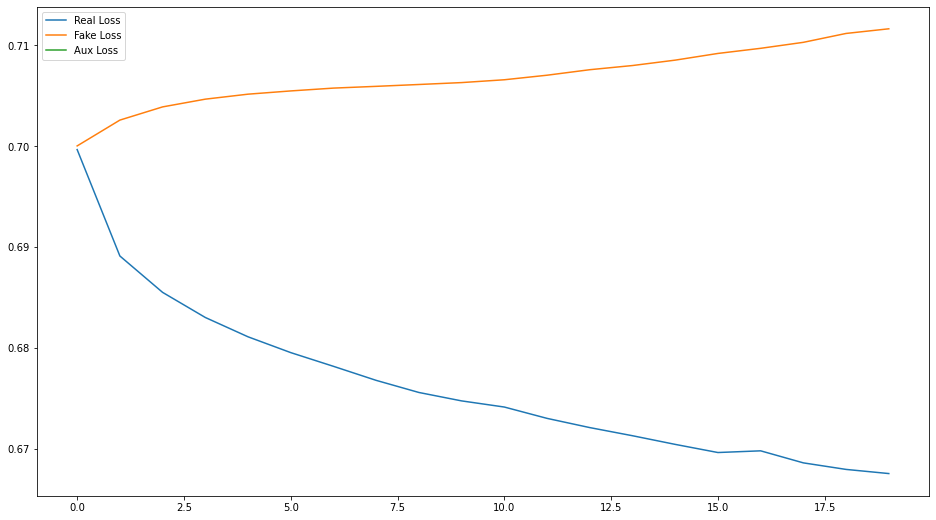

distribution of real data:


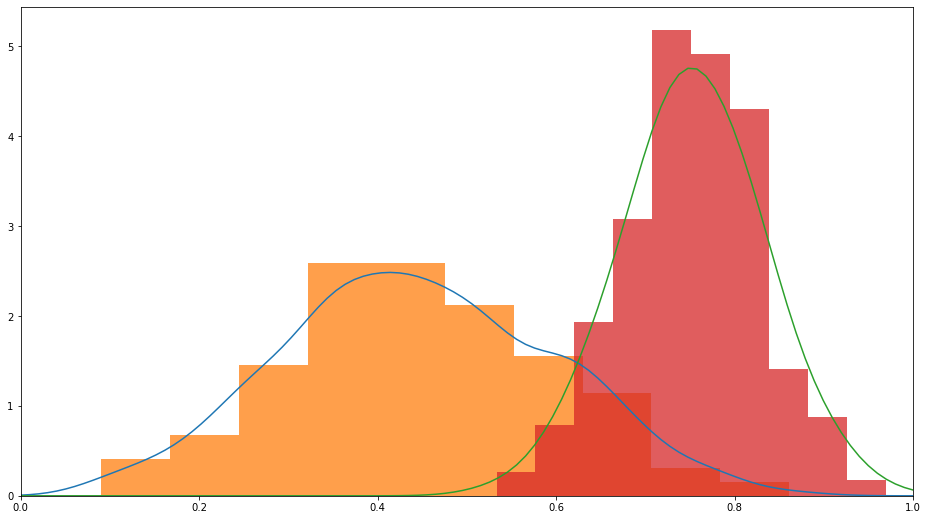

distribution of generated data:


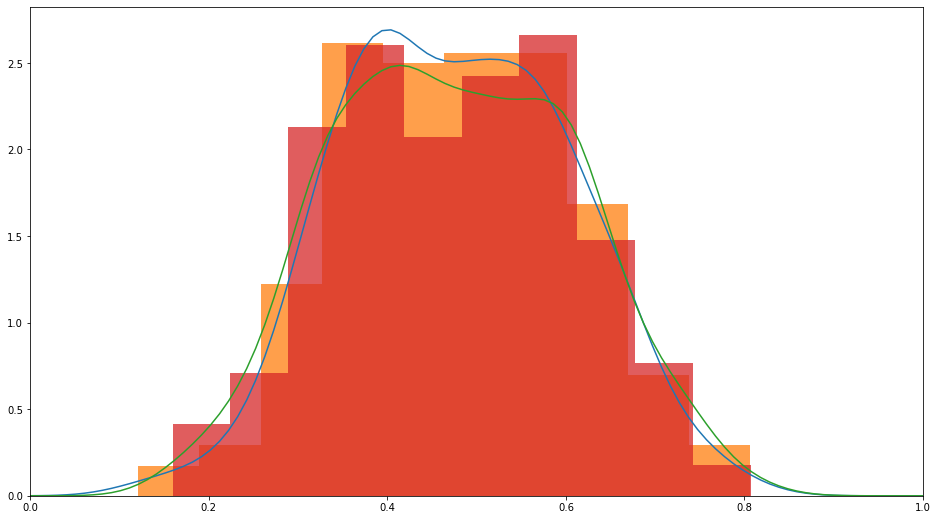

In [10]:
#hide

n_samples = 1024
n_classes = 2
n_features = 1
batch_size = 512
n_z = 10
n_in = n_features
n_hidden = 64
epochs = 5

data = GaussianDataset(n_samples, n_classes)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

model = get_gan_model(structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, bn=True, gan_type='bce')
#print(model)    
for e in tqdm(range(epochs)):
    for x_cat, x_cont, y in dl:
        x_cat = x_cat.to(model.device).long()
        x_cont = x_cont.to(model.device)
        y = y.to(model.device)
        model.train_discriminator(x_cat, x_cont, y)
        model.train_generator(x_cat, x_cont, y)

plt.figure(figsize=(16, 9))
plt.plot(model.real_loss, label='Real Loss')
plt.plot(model.fake_loss, label='Fake Loss')
plt.plot(model.aux_loss, label='Aux Loss')
plt.legend()
plt.show()

model.eval()
z = model.noise(x_cont)
x_fake = model.generator(x_cat, z)

print('distribution of real data:')
plot_class_hists(x_cat.cpu(), x_cont.cpu())

print('distribution of generated data:')
plot_class_hists(x_cat.cpu(), x_fake.cpu().detach())

In [11]:
# export

#class GANCNN(torch.nn.Module):
#    def __init__(self, ann_structure, n_z=100, len_ts=1, bn_cont=False, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, embedding_module=None, transpose=False):
#        super(GANCNN, self).__init__()
#        
#        self.conv_net = TemporalCNN(cnn_structure=ann_structure, batch_norm_cont=bn_cont, 
#                                    cnn_type='cnn', act_func=act_fct, 
#                                    # TODO: this is not the final layer
#                                    final_activation=act_fct, transpose=transpose)
#        self.transpose = transpose
#        if self.transpose:
#            if final_act_fct is not None:
#                self.model_in = nn.Sequential(nn.Linear(n_z, ann_structure[0]*len_ts), final_act_fct(),
#                                          nn.Unflatten(1, (ann_structure[0], len_ts))
#                                         )
#            else:
#                self.model_in = nn.Sequential(nn.Linear(n_z, ann_structure[0]*len_ts),
#                                          nn.Unflatten(1, (ann_structure[0], len_ts))
#                                         )
#        if not self.transpose:
#            # TODO ugly
#            if final_act_fct is not None:
#                self.model_out = nn.Sequential(nn.Flatten(), nn.Linear(len_ts, len_ts), final_act_fct())
#            else:
#                self.model_out = nn.Sequential(nn.Flatten(), nn.Linear(len_ts, len_ts))
#        
#    def forward(self, x_cat, x_cont):
#        if self.transpose:
#            x = self.model_in(x_cont)
#            x = self.conv_net(x_cat, x)
#        else: 
#            x = self.conv_net(x_cat, x_cont)
#            x = self.model_out(x)
#        return x

In [12]:
# hide

#model = GANCNN(ann_structure=[n_in, n_hidden, 1], n_z=100, len_ts=24, transpose=False)
#print(model)
#opt = torch.optim.Adam(params=model.parameters())
#loss = torch.nn.MSELoss()
#data = DummyDataset(n_samples=100, n_cat_feats=n_in, n_cont_feats=n_in, n_targets=1, n_dim=3)
#dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
#
#errors = []
#
#for epoch in range(epochs):
#    for x_cat, x_cont, y in dl:
#        opt.zero_grad()
#        pred = model(x_cat, x_cont)
#        error = loss(pred, y)
#        error.backward()
#        opt.step()
#    errors.append(error.item())
#    
#assert(errors[0] > errors[-1]) 
#
#plt.figure()
#plt.plot(errors)
#plt.show()

In [13]:
#hide

#generator = GANMLP([n_z, n_hidden, n_in], embedding_module=emb, bn_cont=True)
#discriminator = GANMLP([n_in, n_hidden, 1], bn_cont=True)
#gen_opt = torch.optim.Adam(generator.parameters())
#dis_opt = torch.optim.Adam(discriminator.parameters())
#model = GAN(generator, discriminator, gen_opt, dis_opt, n_z=n_z)
#print(model)
#
#for e in tqdm(range(epochs)):
#    for x_cat, x_cont, y in dl:
#        x_cat = x_cat.to(model.device).long()
#        x_cont = x_cont.to(model.device)
#        y = y.to(model.device)
#
#        model.train_discriminator(x_cat, x_cont, y)
#        model.train_generator(x_cat, x_cont, y)
#
#plt.figure()
#plt.plot(model.real_loss, label='Real Loss')
#plt.plot(model.fake_loss, label='Fake Loss')
#plt.legend()
#plt.show()
#
#assert(np.abs(model.real_loss[-1] - model.fake_loss[-1]) < 0.5)
#
#z = model.noise(x_cont)
#x_fake = model.generator(x_cat, z)
#assert((x_fake - x_cont).mean().abs().item() < 0.5)
#
#print('distribution of real data:')
#plot_class_hists(x_cat.cpu(), x_cont.cpu())
#
#print('distribution of generated data:')
#plot_class_hists(x_cat.cpu(), x_fake.cpu().detach())

In [14]:
#hide

#generator = GANMLP([n_z, n_hidden,  n_in], embedding_module=emb, bn_cont=True)
#discriminator = GANMLP([n_in, n_hidden, 1], final_act_fct=nn.Identity, bn_cont=True)
#gen_opt = torch.optim.RMSprop(generator.parameters())
#dis_opt = torch.optim.RMSprop(discriminator.parameters())
#model = WGAN(generator, discriminator, gen_opt, dis_opt, n_z=n_z)
#print(model)
#
#for e in tqdm(range(epochs)):
#    for x_cat, x_cont, y in dl:
#        x_cat = x_cat.to(model.device).long()
#        x_cont = x_cont.to(model.device)
#        y = y.to(model.device)
#
#        model.train_discriminator(x_cat, x_cont, y)
#        model.train_generator(x_cat, x_cont, y)
#
#plt.figure()
#plt.plot(model.real_loss, label='Real Loss')
#plt.plot(model.fake_loss, label='Fake Loss')
#plt.legend()
#plt.show()
#
#z = model.noise(x_cont)
#x_fake = model.generator(x_cat, z)
#
#print('distribution of real data:')
#plot_class_hists(x_cat.cpu(), x_cont.cpu())
#
#print('distribution of generated data:')
#plot_class_hists(x_cat.cpu(), x_fake.cpu().detach())

In [15]:
#hide

#generator = GANMLP([n_z, n_hidden, n_hidden, n_in], embedding_module=emb, bn_cont=True)
#discriminator = GANMLP([n_in, n_hidden, n_hidden], final_act_fct=nn.ReLU, bn_cont=True)
#discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=n_classes, final_input_size=n_hidden, len_ts=1)
#gen_opt = torch.optim.Adam(generator.parameters())
#dis_opt = torch.optim.Adam(discriminator.parameters())
#model = GAN(generator, discriminator, gen_opt, dis_opt, n_z=n_z, auxiliary=True, auxiliary_weighting_factor=1)
#print(model)
#
#for e in tqdm(range(epochs)):
#    for x_cat, x_cont, y in dl:
#        x_cat = x_cat.to(model.device).long()
#        x_cont = x_cont.to(model.device)
#        y = y.to(model.device)
#
#        model.train_discriminator(x_cat, x_cont, y)
#        model.train_generator(x_cat, x_cont, y)
#
#plt.figure()
#plt.plot(model.real_loss, label='Real Loss')
#plt.plot(model.fake_loss, label='Fake Loss')
#plt.plot([a.item() for a in model.aux_loss], label='Aux Loss')
#plt.legend()
#plt.show()
#
#z = model.noise(x_cont)
#x_fake = model.generator(x_cat, z)
#
#print('distribution of real data:')
#plot_class_hists(x_cat.cpu(), x_cont.cpu())
#
#print('distribution of generated data:')
#plot_class_hists(x_cat.cpu(), x_fake.cpu().detach())